<a href="https://colab.research.google.com/github/lukeolson/imperial-multigrid/blob/master/lecture-3-amg-basics/15-CF-AMG-interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# you may need to install pyamg
!pip install pyamg

/bin/sh: pip: command not found


In [1]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

%matplotlib inline

import pyamg

### Pick out a unstructured problem from the gallery

In [2]:
data = pyamg.gallery.load_example('unit_square')
A = data['A'].tocsr()
V = data['vertices'][:A.shape[0]]               # vertices of each variable
E = np.vstack((A.tocoo().row,A.tocoo().col)).T  # edges of the matrix graph
#A = pyamg.gallery.poisson((5,5)).tocsr()

In [3]:
A

<191x191 sparse matrix of type '<class 'numpy.float64'>'
	with 1243 stored elements in Compressed Sparse Row format>

In [5]:
ml = pyamg.ruge_stuben_solver(A, keep=True,
                              strength=('classical',
                                        {'theta': 0.25,
                                         'norm': 'min'}))
print(ml)

multilevel_solver
Number of Levels:     4
Operator Complexity:  1.422
Grid Complexity:      1.356
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0          191         1243 [70.35%]
    1           51          407 [23.03%]
    2           14          108 [ 6.11%]
    3            3            9 [ 0.51%]



### Plot the coarse grid

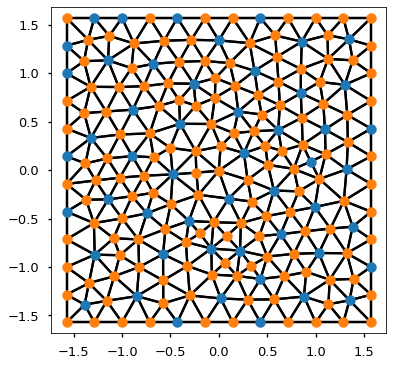

In [6]:
plt.figure(figsize=(6,6))
plt.axis('equal')
splitting = ml.levels[0].splitting
C_nodes = splitting == 1
F_nodes = splitting == 0
for e in E:
    plt.plot(V[e,0], V[e,1], 'k-', zorder=1)
    
plt.scatter(V[:,0][C_nodes], V[:,1][C_nodes], s=100.0, zorder=2)  #plot C-nodes in blue
plt.scatter(V[:,0][F_nodes], V[:,1][F_nodes], s=100.0, zorder=2)  #plot F-nodes in orange

###  Inspect P

Here we will look more closely at P.

First, separate $P$ into
$$
P =
\begin{bmatrix}P_F \\ P_C\end{bmatrix}
$$

In [7]:
P = ml.levels[0].P
splitting = ml.levels[0].splitting
C = np.where(splitting==1)[0]
F = np.where(splitting==0)[0]
PF = P[F,:]
PC = P[C,:]
Preordered = np.zeros(P.shape)
Preordered[:PF.shape[0],:] = PF.toarray()
Preordered[-PC.shape[0]:,:] = PC.toarray()

(0.0, 51.0, 0.0, 191.0)

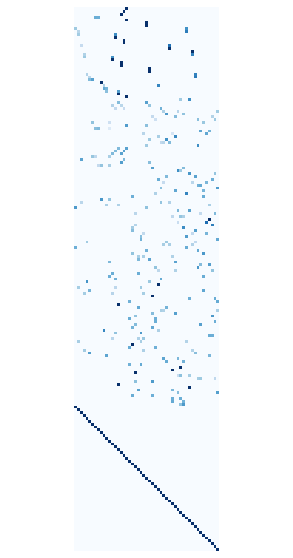

In [8]:
plt.figure(figsize=(5,10))
plt.pcolor(np.flipud(Preordered), cmap='Blues', snap=True)
plt.axis('equal')
plt.axis('off')

Next create
$$
P_{ideal} = -A_{FF}^{-1} A_{FC}
$$

In [9]:
AFFinv = sparse.linalg.inv(A[F,:][:,F].tocsc())
AFC = A[F,:][:,C]

In [10]:
P.shape

(191, 51)

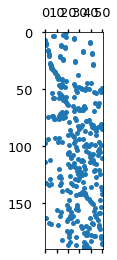

In [11]:
plt.spy(P, marker='.')

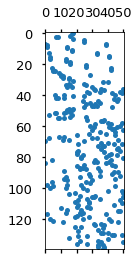

In [12]:
plt.spy(PF, marker='.')

# Compare P and Pideal

Here we'll plot the values (sparsity pattern) of the matrices $P$ and $P_{idea}$

(0.0, 140.0)

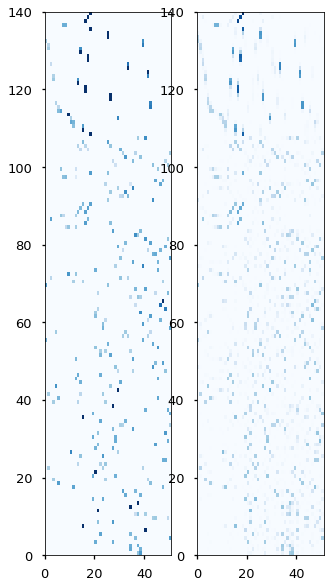

In [13]:
PFa = PF.toarray()
Pideal = (-AFFinv * AFC).toarray()
#I, J = np.where(Pideal < 1e-2)
#Pideal[I,J] = 0.0

fig, ax = plt.subplots(1,2,figsize=(5,10))

pc = ax[0].pcolor(np.flipud(PFa), cmap='Blues', snap=True)
ax[0].set_xlim(0,PF.shape[1])
ax[0].set_ylim(0,PF.shape[0])

pc = ax[1].pcolor(np.flipud(Pideal), cmap='Blues', snap=True)
ax[1].set_xlim(0,Pideal.shape[1])
ax[1].set_ylim(0,Pideal.shape[0])

Go back and try this for a structured $A$

In [42]:
np.linalg.eig(A[F,:][:,F].toarray())[0].min()

0.6525454726507357